In [1]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

import sys
sys.path.insert(1, './lib/')

# Discovering Classic Rock Subgenres
### Team Diatonics | CS 418 | Spring 2020

### Team Members
* Leopoldo Gomez (`lgomez36@uic.edu`, `pologomez`), Matthew Searcy (`msearc2@uic.edu`, `MatthewSearcy`),  Matt Rusnaczyk (`mrusna4@uic.edu`, `mrusnaczyk`), Faraz Shakir (`fshaki3@uic.edu`, `FShakir`), Mahdi Moghaddam (`mmogha2@uic.edu`, `mahdimo5595`)

------

## Project Introduction
In it's current form, the main idea of this project is to see if a clustering method can be used to subdivide a large pool of songs that are deemed to be part of the same genre into smaller subgenres. A potential audience for this analysis would be people who are trying to get into a new gerne. Being able to listen to a selection of songs from each subgroup could make it easier to figure out what type of bands they'd enjoy listening to. 

For our preliminary exploration into this topic we decided to use a precompiled [dataset](https://github.com/fivethirtyeight/data/blob/master/classic-rock/classic-rock-song-list.csv) of classic rock songs and get their audio features via spotify's API. We decided to use rock as our genre for this because it is one of the broadest genres of music with many distinct characteristic sounds and sub-cultures. If the preliminary results are fruitful we may continue on to broadening the genres we cluster from.

## Changes to Scope of Project
### Spotify Listening Trends Based on Time of Year
   Originally, our project was going to focus on the songs that gain popularity at different times of the year. We wondered if there was some correspondence between the properties of those songs and the time at which they reached peak popularity and see if we could predict the optimal time of year to release a new song given its properties.
   Our course of action was to fetch the top 100 songs from the Billboard charts every week of the year for the past 20 years. We would then retrieve the songs' properties using the Spotify API and organize the data for comparison and use machine learning to develop a way of classifying a song into seasons based on its properties.
   
   We decided to change our project's scope for a few reasons. When we examined the properties of the songs we gathered, virtually every week had a wide variety of levels of energy, key, loudness, etc. We concluded that there wasn't significance in the seasonality of the songs and that would likely lead to an inaccurate classification model. Since the hot-100 charts features songs of all varieties, we decided we'd have to hone in on a type of music to make the properties of the songs more similar. Additionally, a song that is on the Billbord hot-100 list often remains on the list for weeks, or even months. This resulted in complications in identifying the season that the song gained popularity, and would likely affect the learning.

---

## Data Acquisition and Cleaning
Our analysis is based on two sets of data. The first is the [Classic Rock Song List from FiveThirtyEight](https://github.com/fivethirtyeight/data/blob/master/classic-rock/classic-rock-song-list.csv); the second is the audio features data made available by Spotify through their [RESTful API](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/).

First, we read in the data from the classic rock songs dataset, then we transform the data into a list consisting of each track and artist concatenated into one string. Converting into this format allows us to more easily search for the tracks in Spotify later on.

In [2]:
import data_acquisition_cleaning as data
raw_song_data = data.load_song_data()
title_artist = data.get_title_artist(raw_song_data)

Next, we take the title/artist strings we generated earlier, and retrieve the corresponding Spotify resource URLs for each:

In [3]:
%%capture
import spotify
spotify_client = spotify.get_spotify_client()
tracks_to_query = spotify.get_spotify_resource_urls(title_artist, spotify_client)

Then, we use the Spotify API to retrieve the audio features for each of the songs in the list, and add the track name and artist back in:

In [4]:
tracks_with_audio_features = spotify.audio_features(tracks_to_query, spotify_client)

retrying ...2secs


And this is the resulting dataset:

In [6]:
tracks_with_audio_features.head()

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,title,artist
0,0.425,0.681,1,-8.604,0.0316,0.02290,0.000219,0.0543,0.933,131.011,Caught Up in You,.38 Special
1,0.418,0.775,4,-9.591,0.0333,0.05310,0.001250,0.0932,0.845,123.524,Fantasy Girl,.38 Special
2,0.567,0.559,9,-10.175,0.0288,0.00888,0.001310,0.0764,0.898,127.227,Hold On Loosely,.38 Special
3,0.659,0.505,0,-12.773,0.0302,0.05300,0.000000,0.0544,0.879,128.295,Rockin' Into the Night,.38 Special
4,0.646,0.426,0,-10.629,0.0480,0.08580,0.072700,0.0746,0.462,124.794,Art For Arts Sake,10cc


## Exploratory Data Analysis


In [6]:
eda_data = tracks_with_audio_features.copy().dropna()
try:
    eda_data = eda_data.drop(columns=['cluster', 'tempo'])
except:
    None
eda_data.describe()

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,2174.000000,2174.00000,2174.000000,2174.000000,2174.000000,2174.000000,2174.000000,2174.000000,2174.000000,2174.000000
mean,0.524409,0.68872,5.016099,-8.943381,0.052493,0.183860,0.067784,0.206573,0.601098,124.178644
std,0.140208,0.19306,3.506646,3.337211,0.040275,0.219819,0.183529,0.188982,0.228581,27.048196
min,0.000000,0.01240,0.000000,-23.340000,0.000000,0.000001,0.000000,0.012000,0.000000,0.000000
25%,0.432000,0.55425,2.000000,-11.229750,0.032400,0.015225,0.000007,0.086600,0.429000,105.414000
50%,0.531000,0.71600,5.000000,-8.749000,0.039900,0.089950,0.000463,0.131500,0.614000,123.421000
75%,0.622000,0.84700,9.000000,-6.356000,0.056175,0.290000,0.015150,0.269750,0.787750,139.835000
max,0.952000,0.99500,11.000000,-1.525000,0.507000,0.971000,0.949000,0.992000,0.990000,215.918000


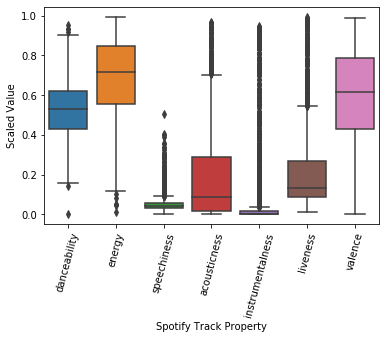

In [7]:
import viz
viz.spotify_property_dist_graph(eda_data)
plt.show()

---
## Machine Learning Analysis

In [7]:
import ml_analysis as ml
# scalling loudness, key, and tempo so the values of all features are between 0 and 1
scaler = MinMaxScaler()
ml.scale_columns(['loudness', 'key', 'tempo'], tracks_with_audio_features, scaler)

In [25]:
(tracks_with_audio_features,center) = ml.cluster_songs(tracks_with_audio_features, 50)

In [26]:
tracks_with_audio_features.head()

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,title,artist,cluster
0,0.425,0.681,0.090909,0.675499,0.0316,0.02290,0.000219,0.0543,0.933,0.606763,Caught Up in You,.38 Special,44
1,0.418,0.775,0.363636,0.630254,0.0333,0.05310,0.001250,0.0932,0.845,0.572088,Fantasy Girl,.38 Special,35
2,0.567,0.559,0.818182,0.603484,0.0288,0.00888,0.001310,0.0764,0.898,0.589238,Hold On Loosely,.38 Special,31
3,0.659,0.505,0.000000,0.484391,0.0302,0.05300,0.000000,0.0544,0.879,0.594184,Rockin' Into the Night,.38 Special,20
4,0.646,0.426,0.000000,0.582672,0.0480,0.08580,0.072700,0.0746,0.462,0.577969,Art For Arts Sake,10cc,11


In [27]:
center

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,title,artist,cluster
297,0.382,0.589,0.818182,0.734586,0.0267,0.046500,0.000000,0.1220,0.3350,0.648668,Heaven,Bryan Adams,0
1456,0.526,0.645,0.454545,0.656796,0.0375,0.294000,0.000003,0.1070,0.4160,0.461453,TIME IS ON MY SIDE,Rolling Stones,1
279,0.535,0.884,0.818182,0.817832,0.0407,0.001880,0.001260,0.1400,0.7960,0.558337,Cover Me,Bruce Springsteen,2
862,0.390,0.648,0.727273,0.621178,0.1370,0.004280,0.053100,0.6890,0.4930,0.479330,If 6 Was 9,Jimi Hendrix,3
1192,0.315,0.938,0.090909,0.782764,0.0860,0.004990,0.000056,0.1900,0.5270,0.580206,Flying High Again,Ozzy Osbourne,4
1797,0.370,0.403,0.636364,0.417740,0.0302,0.111000,0.005390,0.0727,0.2000,0.522397,Good Friday,The Black Crowes,5
380,0.589,0.850,0.181818,0.788311,0.0343,0.060600,0.779000,0.2740,0.8130,0.603553,Up Around the Bend,Creedence Clearwater Revival,6
982,0.599,0.744,0.636364,0.670181,0.0316,0.131000,0.002750,0.0795,0.7230,0.422656,All My Love,Led Zeppelin,7
1516,0.437,0.279,0.181818,0.401879,0.0325,0.505000,0.016100,0.1330,0.3000,0.546592,Holiday,Scorpions,8
674,0.537,0.701,0.090909,0.661334,0.0335,0.097200,0.000000,0.0832,0.5830,0.560023,My Sweet Lord,George Harrison,9


Now, we can recommend similar songs to users based on the cluster that they belong to. For example, someone who listens to 'Back in Black' might also enjoy the following songs:

In [31]:
ml.recommend('Back In Black', "AC/DC", tracks_with_audio_features, spotify_client,tracks_to_query).head(10)

,artist,title
11,AC/DC,Back In Black
42,Aerosmith,"Baby, Please Don't Go"
67,Aerosmith,Toys in the Attic
90,Alice In Chains,Them Bones
111,April Wine,Roller
184,Black Sabbath,Iron Man
200,Blue Oyster Cult,(Don't Fear) The Reaper
247,Bon Jovi,Runaway
305,Bush,Comedown
340,Clarks,Better Off Without You


In [30]:
ml.recommend('Roar', "katy perry", tracks_with_audio_features, spotify_client,tracks_to_query).head(10)

,artist,title
6,3 Doors Down,Loser
7,3 Doors Down,When I'm Gone
20,AC/DC,Highway To Hell
25,AC/DC,Live Wire
26,AC/DC,Moneytalks
34,AC/DC,Touch Too Much
47,Aerosmith,Cryin'
86,Alice In Chains,Down in a Hole
228,Bob Seger,Mainstreet
346,Clarks,The River


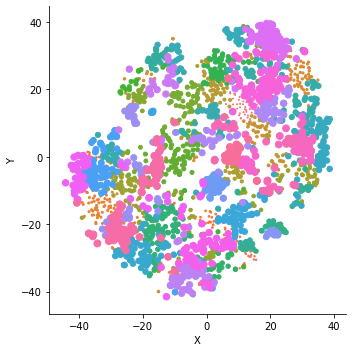

In [15]:
tsnedf = tracks_with_audio_features.copy().drop(columns=['artist', 'title', 'cluster'])
model = TSNE(n_components=2, random_state=0, perplexity=50, learning_rate=900)
tsne_object = model.fit_transform(tsnedf)
tsne_df = pd.DataFrame(data=tsne_object, columns=('X', 'Y'))
tsne_df['cluster'] = clusters
sns.FacetGrid(tsne_df, hue='cluster', height=5).map(plt.scatter, 'X', 'Y', 'cluster')
plt.show()

In [ ]:
dataframe['baseline'] = 0
i = 0
j = 0
while(True):
    if j+42 < len(urls):
        dataframe.loc[j:j+42,:].baseline = i
        j = j+43
        i = i+1
    else:
        dataframe.loc[j:len(urls),:].baseline = i
        break

## Reflection
The hardest parts of the project have been figuring out what data to acquire and cleaning it and proper version control with Jupyter Notebooks.  The biggest initial insight we found is that our initial hypothesis of seasonality in data is not true, and the low hanging fruit of Spotify data was already taken by another project.  We have used the t-SNE methodology in order to obtain a map of the clusters, representing subgenres of rock music.  We have not yet added labels to these clusters, and we still need to get a proper accuracy in spite of the unsupervised learning we have used as a base, which is also our next pressing issue.  The team is on track with the project and we foresee being able to complete it on schedule.  Despite the difficulty in figuring out the project's goals, we believe it is worth proceeding as we now have a goal and a means to get there

---

## Next Steps
Our next steps are mainly to work on our machine learing process. We need to add labels to our clusters and try to improve our accuracy. 